In [1]:
%pip install ucimlrepo pandas numpy scikit-learn openpyxl requests


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import requests
from io import BytesIO

# ML imports
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from collections import defaultdict
import matplotlib.pyplot as plt

### Download and import UC-Irvine online retail dataset

In [3]:
# Download the Online Retail dataset from UCI repository using requests
# (requests handles SSL better than urllib)
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx"

print("Downloading Online Retail dataset from UCI repository...")
try:
    # Use requests library which handles SSL certificates better
    response = requests.get(url, verify=False)  # verify=False bypasses SSL verification
    response.raise_for_status()
    
    # Read the Excel file from the downloaded content
    df = pd.read_excel(BytesIO(response.content), engine='openpyxl')
    print("✓ Dataset loaded successfully!")
    
    # Display dataset information
    print(f"\nDataset shape: {df.shape}")
    print(f"Rows: {df.shape[0]:,}, Columns: {df.shape[1]}")
    print(f"\nColumns: {list(df.columns)}")
    print(f"\nFirst few rows:")
    display(df.head())
    print(f"\nData types:")
    # print(df.dtypes)
    # print(f"\nBasic statistics:")
    # print(df.describe())
    
except Exception as e:
    print(f"Error: {e}")
    print("\nPlease check your internet connection or try again later.")

/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'archive.ics.uci.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


✓ Dataset loaded successfully!

Dataset shape: (541909, 8)
Rows: 541,909, Columns: 8

Columns: ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country']

First few rows:


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom



Data types:


### Preprocess into a pricing learning table

In [4]:
def preprocess(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # Parse datetime
    df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"], errors="coerce")
    df = df.dropna(subset=["InvoiceDate", "StockCode", "Quantity", "UnitPrice"])

    # Remove cancellations/returns and non-positive values
    # UCI notes InvoiceNo starting with 'C' indicates cancellation. :contentReference[oaicite:4]{index=4}
    df["InvoiceNo"] = df["InvoiceNo"].astype(str)
    df = df[~df["InvoiceNo"].str.startswith("C")]
    df = df[(df["Quantity"] > 0) & (df["UnitPrice"] > 0)]

    # Keep only products with enough observations (helps learning stability)
    df = df[df["StockCode"].astype(str).str.len() > 0]

    # Aggregate to daily product level
    df["date"] = df["InvoiceDate"].dt.date
    g = df.groupby(["StockCode", "date"], as_index=False).agg(
        qty=("Quantity", "sum"),
        price=("UnitPrice", "mean"),
        n_txn=("InvoiceNo", "nunique"),
    )

    # Add time features
    g["date"] = pd.to_datetime(g["date"])
    g["dow"] = g["date"].dt.dayofweek
    g["month"] = g["date"].dt.month

    # Lag features (per product)
    g = g.sort_values(["StockCode", "date"])
    g["qty_lag1"] = g.groupby("StockCode")["qty"].shift(1)
    g["qty_lag7"] = g.groupby("StockCode")["qty"].shift(7)

    # Fill missing lags with 0 (cold start)
    g[["qty_lag1", "qty_lag7"]] = g[["qty_lag1", "qty_lag7"]].fillna(0)

    return g

data = preprocess(df)
display(data.tail(20))


,StockCode,date,qty,price,n_txn,dow,month,qty_lag1,qty_lag7
276128,gift_0001_20,2011-04-19,1,16.67,1,1,4,2.0,0.0
276129,gift_0001_20,2011-06-20,1,16.67,1,0,6,1.0,0.0
276130,gift_0001_20,2011-06-24,1,16.67,1,4,6,1.0,0.0
276131,gift_0001_20,2011-08-04,1,16.67,1,3,8,1.0,1.0
276132,gift_0001_20,2011-10-31,1,16.67,1,0,10,1.0,1.0
276133,gift_0001_30,2011-01-05,1,25.53,1,2,1,0.0,0.0
276134,gift_0001_30,2011-02-17,1,25.00,1,3,2,1.0,0.0
276135,gift_0001_30,2011-02-18,1,25.00,1,4,2,1.0,0.0
276136,gift_0001_30,2011-05-31,1,25.00,1,1,5,1.0,0.0
276137,gift_0001_30,2011-08-10,1,25.00,1,2,8,1.0,0.0


In [5]:
data['StockCode'].nunique()

3922

### Fit a simple demand model from offline data:

$$ log(1+qty) = \beta_0 + \beta_1 log(price) + context $$

In [6]:
def fit_demand_model(data: pd.DataFrame):
    d = data.copy()
    d["log_qty"] = np.log1p(d["qty"])
    d["log_price"] = np.log(d["price"])

    # identify which features are numerical and which are categorical
    features_num = ["log_price", "qty_lag1", "qty_lag7", "n_txn"]
    features_cat = ["dow", "month"]

    X = d[features_num + features_cat]
    y = d["log_qty"]

    # For numerical features, we pass them through as-is
    # For categorical features, we apply one-hot encoding
    pre = ColumnTransformer(
        transformers=[
            ("num", "passthrough", features_num),
            ("cat", OneHotEncoder(handle_unknown="ignore"), features_cat),
        ]
    )

    # Build the full pipeline with preprocessing and (Ridge)-regression model
    model = Pipeline(steps=[
        ("pre", pre),
        # ("reg", Ridge(alpha=1.0)),
        ("reg", LinearRegression()),
    ])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=0)
    model.fit(X_train, y_train)

    r2 = model.score(X_test, y_test)
    print(f"Demand model R^2 on log_qty: {r2:.3f}")
    return model

demand_model = fit_demand_model(data)


Demand model R^2 on log_qty: 0.470


In [7]:
# Extract and display demand model coefficients
def extract_demand_coefficients(model, data):
    """
    Extract and interpret coefficients from the demand model.
    
    Args:
        model: Trained sklearn Pipeline with preprocessing and regression
        data: DataFrame used for training (to get feature names)
    
    Returns:
        DataFrame with coefficient names and values
    """
    # Get the regression model (last step in pipeline)
    reg_model = model.named_steps['reg']
    
    # Get feature names from the preprocessor
    preprocessor = model.named_steps['pre']
    
    # Get feature names after transformation
    feature_names = []
    
    # Numerical features (passthrough)
    num_features = ["log_price", "qty_lag1", "qty_lag7", "n_txn"]
    feature_names.extend(num_features)
    
    # Categorical features (one-hot encoded)
    cat_transformer = preprocessor.named_transformers_['cat']
    cat_feature_names = cat_transformer.get_feature_names_out(['dow', 'month'])
    feature_names.extend(cat_feature_names)
    
    # Get coefficients
    coefficients = reg_model.coef_
    intercept = reg_model.intercept_
    
    # Create DataFrame
    coef_df = pd.DataFrame({
        'Feature': ['Intercept'] + feature_names,
        'Coefficient': [intercept] + list(coefficients),
        'Abs_Coefficient': [abs(intercept)] + list(np.abs(coefficients))
    })
    
    # Sort by absolute value to see most important features
    coef_df_sorted = coef_df.sort_values('Abs_Coefficient', ascending=False)
    
    # Print results
    print("=" * 70)
    print("DEMAND MODEL COEFFICIENTS")
    print("=" * 70)
    print(f"\nModel: log(1 + qty) = β₀ + β₁·log(price) + β₂·qty_lag1 + ... + ε\n")
    
    print("Top 10 Most Important Features:")
    print("-" * 70)
    for idx, row in coef_df_sorted.head(10).iterrows():
        feature = row['Feature']
        coef = row['Coefficient']
        print(f"  {feature:25s}: {coef:8.4f}")
    
    print("\n" + "=" * 70)
    print("KEY INSIGHTS")
    print("=" * 70)
    
    # Price elasticity
    price_coef = coef_df[coef_df['Feature'] == 'log_price']['Coefficient'].values[0]
    print(f"\nPrice Elasticity: {price_coef:.4f}")
    if price_coef < 0:
        print(f"  → 1% increase in price → {abs(price_coef):.2f}% decrease in quantity")
        print(f"  → Demand is {'elastic' if abs(price_coef) > 1 else 'inelastic'}")
    else:
        print(f"  → WARNING: Positive price coefficient (unusual!)")
    
    # Lag features
    qty_lag1_coef = coef_df[coef_df['Feature'] == 'qty_lag1']['Coefficient'].values[0]
    qty_lag7_coef = coef_df[coef_df['Feature'] == 'qty_lag7']['Coefficient'].values[0]
    
    print(f"\nLag Effects:")
    print(f"  qty_lag1: {qty_lag1_coef:7.4f} → Yesterday's demand {'increases' if qty_lag1_coef > 0 else 'decreases'} today's")
    print(f"  qty_lag7: {qty_lag7_coef:7.4f} → Last week's demand {'increases' if qty_lag7_coef > 0 else 'decreases'} today's")
    
    # Day of week effects
    print(f"\nDay of Week Effects:")
    dow_features = coef_df[coef_df['Feature'].str.contains('dow_')]
    for _, row in dow_features.iterrows():
        day_num = row['Feature'].split('_')[-1]
        days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
        day_name = days[int(float(day_num))] if day_num.replace('.', '').isdigit() else day_num
        print(f"  {day_name}: {row['Coefficient']:7.4f}")
    
    print("\n" + "=" * 70)
    
    return coef_df_sorted


# Extract coefficients
coef_df = extract_demand_coefficients(demand_model, data)

# Display full coefficient table
print("\nFull Coefficient Table:")
display(coef_df)


DEMAND MODEL COEFFICIENTS

Model: log(1 + qty) = β₀ + β₁·log(price) + β₂·qty_lag1 + ... + ε

Top 10 Most Important Features:
----------------------------------------------------------------------
  Intercept                :   1.6700
  log_price                :  -0.4813
  n_txn                    :   0.4451
  dow_6                    :  -0.1696
  month_12                 :  -0.1427
  month_11                 :  -0.1329
  month_8                  :   0.1166
  dow_3                    :   0.1032
  month_9                  :   0.1014
  month_5                  :   0.0685

KEY INSIGHTS

Price Elasticity: -0.4813
  → 1% increase in price → 0.48% decrease in quantity
  → Demand is inelastic

Lag Effects:
  qty_lag1:  0.0001 → Yesterday's demand increases today's
  qty_lag7:  0.0001 → Last week's demand increases today's

Day of Week Effects:
  Mon: -0.0374
  Tue:  0.0027
  Wed:  0.0429
  Thu:  0.1032
  Fri:  0.0581
  Sun: -0.1696


Full Coefficient Table:


,Feature,Coefficient,Abs_Coefficient
0,Intercept,1.669960,1.669960
1,log_price,-0.481277,0.481277
4,n_txn,0.445101,0.445101
10,dow_6,-0.169596,0.169596
22,month_12,-0.142702,0.142702
21,month_11,-0.132905,0.132905
18,month_8,0.116640,0.116640
8,dow_3,0.103223,0.103223
19,month_9,0.101424,0.101424
15,month_5,0.068503,0.068503


### Build a simple Reinforcement Learning environment (model-based "offline RL")

In [8]:
# We’ll define actions as price multipliers around the observed price:
ACTION_MULTS = np.array([0.90, 0.95, 1.00, 1.05, 1.10, 1.15, 1.20, 1.25])

State will be a discretized tuple:
- product id
- day-of-week
- lagged-qty bin

Reward: Revenue = chosen price * simulated_qty

Transition:
- lag updates with simulated qty
- day moves forward

### Environment + Q-Learning (tabular --> simple)
- Classic Q-Learning learns a table:
$ Q(s,a) $ 
for every discrete state s and action a
- State space must be finite, action space must be finite
- Every pair (s,a) gets updated many times

### Notes on standard and double-Q Learning
Standard Q-learning learns action-value function $Q(s,a)$ with update:
\begin{equation*}
Q(s_t, a_t) \leftarrow Q(s_t, a_t) + \alpha \bigg( r_t + \gamma \, max_a Q(s_{t+1}, a) - Q(s_t, a_t) \bigg)
\end{equation*}
where $\alpha$ is a parameter that scale how much new information changes old estimate.

Think of it like: $Q_{new} = (1-\alpha) Q_{old} + \alpha (new target)$. So:
- Small $\alpha$ --> learn slowly
- Large $\alpha$ --> learn fast but new Q-value is noisy and can be unstable

$\gamma$ is the discount factor. It weights future rewards relative to immediate reward:
\begin{equation*}
Q(s,at) = E[ r_0 + \gamma r_1 + \gamma^2 r_2 + .... ]
\end{equation*}
So $\gamma=0$, we only care about immediate reward while $\gamma = 1$, long term consequences matter. 

Intuitively, we want RL agent to keep the mindset that "A slightly lower price today may keep demand (quantity) healthy and pay off later"

In standard Q-Learning, we expect overestimating bias:
\begin{equation*}
E \bigg[ max_a Q(s,a) \bigg] \geq max_a E \bigg[ Q(s,a) \bigg]
\end{equation*}
Think of this as max() is convex. So when we take a max over noise then we tend to pick action that is overestimated (by noise).

Bottom line: overestimation lead to aggressive policies (e.g., always increase price)

### Introduce Double-Q Learning:
Double-Q learning keeps 2 separate Q-value estimate:
\begin{align*}
&Q^A(s,a) \\
&Q^B(s,a)
\end{align*}
The trick: 
- use one table to select the best action for next state (argmax)
- use other table to evaluate that selected action
This decouples selection and evaluation --> reducing bias from max operator

Update Rules: At each transition $(s_t, a_t, r_t, s_{t+1})$, flip a coin
- Update $Q^A$ with probability 0.5:
    - Best action selection using $Q^A$: $a^* = argmax_a \, Q^A(s_{t+1},a)$
    - Evaluate that action using $Q^B$: $Y^A_t = r_t + \gamma \, Q^B(s_{t+1}, a^*)$
    - Update $Q^A$:
\begin{equation*}
Q^A (s_t, a_t) \leftarrow Q^A (s_t, a_t) + \alpha \bigg( Y^A_t - Q^A(s_t, a_t) \bigg)
\end{equation*}

- Or Update $Q^B$ with probability 0.5: (using the same workflow & equations)

This approach reduces overestimation because:
- the action choosing task and evaluation task are done using 2 different Q-table
- E.g., best action chosen from $Q^A$ while evaluation done in $Q^B$, or vice versa
- Idea is: don't evaluate action choice using same-noise table: if noise in $Q^A$ and $Q^B$ is imperfectly correlated (they should differ because they're update differently on different steps), then the "lucky high" selection in $Q^A$ should not appear high in $Q^B$. Overall, leading to a less biased evaluation.
- Analogy: use one model for choosing, another model for scoring -- this is a common bias/variance trick


In [9]:
def make_top_products(data: pd.DataFrame, top_k=200):
    """
    Get the top-k products by total quantity sold.
    """
    counts = data.groupby("StockCode")["qty"].sum().sort_values(ascending=False)
    top = counts.head(top_k).index.astype(str).tolist()
    return top

def build_episode_table(data: pd.DataFrame, top_products):
    """
    Build episode table for RL environment using only top products.
    """
    d = data[data["StockCode"].astype(str).isin(top_products)].copy()
    # Use each (product, date) row as a step; we’ll “simulate” what happens next
    d["StockCode"] = d["StockCode"].astype(str)
    d = d.sort_values(["StockCode", "date"])
    return d.reset_index(drop=True)

# Discretize lagged demand into bins
def qty_bin(q):
    """
    Discretize quantity into bins for state representation in Q-learning.
    Remember that qty is the predicted quantity sold. It is the target variable of demand model.
    We need to make the state space finite for tabular Q-learning.
    """
    # simple bins; tweak as desired:
    # We can think of this as the following:
    # q  < 1: no demand
    # 1  < q < 10: very low demand
    # 10 < q < 20: quite low demand
    # 20 < q < 30: still low demand but better
    # 30 < q < 40: low-medium demand
    # 40 < q < 50: medium demand
    # 50 < q < 100: high demand
    # 100< q < 200: very high demand
    # q > 200: extremely high demand
    if q < 1: return 0
    if q < 10: return 1
    if q < 20: return 2
    if q < 30: return 3
    if q < 40: return 4
    if q < 50: return 5
    if q < 100: return 6
    if q < 200: return 7
    return 8

# Using the demand model, predict quantity sold given a price and row features
def predict_qty(model, row_dict, price):
    """
    Predict quantity sold using the demand model.
    row_dict contains features like qty_lag1, qty_lag7, n_txn, dow, month
    Remark: dow and month are integers which will be one-hot encoded by the model
    """
    # Ensure price is positive and reasonable
    price = max(1e-6, float(price))
    
    # Check for invalid values in row_dict
    qty_lag1 = max(0.0, float(row_dict["qty_lag1"]))
    qty_lag7 = max(0.0, float(row_dict["qty_lag7"]))
    n_txn = max(1.0, float(row_dict["n_txn"]))
    
    x = {
        "log_price": np.log(price),
        "qty_lag1": qty_lag1,
        "qty_lag7": qty_lag7,
        "n_txn": n_txn,
        "dow": int(row_dict["dow"]),
        "month": int(row_dict["month"]),
    }
    X = pd.DataFrame([x])
    
    try:
        log_qty = float(model.predict(X)[0])
        # Clip log_qty to prevent extreme values
        log_qty = np.clip(log_qty, -10, 10)
        qty_hat = max(0.0, np.expm1(log_qty))
    except:
        qty_hat = 0.0
    
    return qty_hat


# -----------------------------
# 6) RL environment step
# -----------------------------
def env_step(model, row_dict, action_mult):
    """
    One-step transition:
      action_mult scales the base price
      reward is revenue = price * predicted_qty
      next_state uses qty_bin(predicted_qty)
      we update lags naively for the simulated next step
    """
    base_price = max(1e-6, float(row_dict["price"]))
    action_mult = max(0.1, min(2.0, float(action_mult)))  # Clamp action multiplier
    new_price = max(1e-6, base_price * action_mult)

    # Use demand-model to predict quantity sold at new_price
    qty_hat = predict_qty(model, row_dict, new_price)
    qty_hat = max(0.0, min(10000.0, qty_hat))  # Clamp quantity to reasonable range
    
    # compute reward using updated new_price
    # so that the method will learn how to pick price multiplier that maximizes expected revenue
    reward = new_price * qty_hat

    # Note: the predicted qty_hat is continuous, so we need to bin them to create discrete state value for quantity sold
    next_state = qty_bin(qty_hat)

    # Build the next row (next "state features") -- We need to know what carries forward
    # tomorrow's lag1 becomes today's predicted quantity
    # tomorrow's lag7 become today's lag1
    # Update lags for next step
    next_row = dict(row_dict)
    next_row["qty_lag7"] = max(0.0, float(row_dict["qty_lag1"]))
    next_row["qty_lag1"] = max(0.0, float(qty_hat))
    next_row["price"] = new_price
    # Keep other context fields stable
    next_row["n_txn"] = max(1.0, float(row_dict.get("n_txn", 1)))
    next_row["dow"] = int(row_dict["dow"])
    next_row["month"] = int(row_dict["month"])
    # return Q-learning expects (signature variables)
    return next_state, reward, next_row


# -----------------------------
# 7) Q-learning with Advanced Updates
# -----------------------------
def q_learning(
    ep_table: pd.DataFrame,
    demand_model,
    actions=(0.9, 1.0, 1.1),
    episodes=5000,
    horizon=20,
    alpha=0.1,
    gamma=0.9,
    epsilon=0.25,
    seed=0,
    update_method="double_q",  # "bellman", "double_q", "expected_sarsa", "n_step"
    n_step=3,  # for n-step returns
):
    """
    Tabular Q-learning with multiple update methods.
    
    Update Methods:
    - "bellman": Standard Q-learning (max over next state)
    - "double_q": Double Q-Learning (reduces maximization bias)
    - "expected_sarsa": Expected SARSA (uses expected value instead of max)
    - "n_step": N-step Q-learning (uses multi-step returns)
    """
    rng = np.random.default_rng(seed)

    actions = np.array(list(actions), dtype=float)
    n_states = 9
    n_actions = len(actions)
    
    if update_method == "double_q":
        # Double Q-Learning uses two Q-tables (2 separate estimates to reduce overestimation)
        Q1 = np.zeros((n_states, n_actions), dtype=float)
        Q2 = np.zeros((n_states, n_actions), dtype=float)
    else:
        Q = np.zeros((n_states, n_actions), dtype=float)

    # Loop over episodes and randomly sampled starting points
    # Goal: learn a pricing policy that maximizes EXPECTED long-term revenue across various products (states) and time periods
    for _ in range(episodes):
        # sample a random start row from ep_table 
        r = ep_table.iloc[int(rng.integers(0, len(ep_table)))].to_dict()
        # initial state is based on lagged demand, not current demand
        s = qty_bin(float(r["qty_lag1"]))
        
        # For n-step, store trajectory
        if update_method == "n_step":
            trajectory = []

        # Remark: we need to loop through the horizon steps because one episode in Q-learning can span multiple time steps
        #         Think of it as simulating a sequence of decisions within one episode to capture temporal dynamics
        #         Each step within the episode represents a decision point where the agent selects an action, observes the outcome, and updates its knowledge
        #         This allows the agent to learn from a sequence of interactions rather than a single decision
        #         Mind set: "Today's price decision affects not just today's revenue but also future states and rewards"
        #         Goal: learn a pricing policy that maximizes long-term revenue over multiple time steps NOT just immediate reward (revenue)
        # Mathematically, we are estimating:
        # Q[s,a] ~ E[
        #       sum_{t=0,...,infinity} \gamma^t reward_t | s0=s, a0=a
        # ]
        # That expectation is over a trajectory of states and rewards aka transitions
        # (s0,a0,reward0,s1) , (s1,a1,reward1,s2) , ...
        # Rule of thumb: effective horizon is roughly 1/(1-gamma)
        for t in range(horizon):
            # epsilon-greedy action selection:
            # given the current state s, available actions, current Q1,Q2 estimates
            # decide: try something new? or use what I've learnt so far
            #         with probability epsilon: explore (random action) and probability 1-epsilon: exploit (best known action)
            if update_method == "double_q":
                # Use average Q-values for action selection: this reduces variance, avoids trusting one noisy estimate, gives a more stable actions ranking
                q_avg = (Q1[s] + Q2[s]) / 2
                if rng.random() < epsilon:
                    a = int(rng.integers(0, n_actions))     # explore other action choice randomly
                else:
                    a = int(np.argmax(q_avg))               # use best-action, determined by largest Q-value from Q_avg table
            else:
                if rng.random() < epsilon:
                    a = int(rng.integers(0, n_actions))
                else:
                    a = int(np.argmax(Q[s]))
            # once we have chosen action a in actions list, we can simulate step
            # i.e., computing next state s2, reward and next row
            s2, reward, r = env_step(demand_model, r, actions[a])

            # ========== UPDATE RULES ==========
            
            if update_method == "bellman":
                # Standard Bellman Q-Learning:
                # Often overestimate due to using max() bias
                Q[s, a] = Q[s, a] + alpha * (reward + gamma * np.max(Q[s2]) - Q[s, a])
            
            elif update_method == "double_q":
                # Double Q-Learning: Randomly choose which Q to update
                # Double Q-learning reduce maximization bias
                if rng.random() < 0.5:
                    # Update Q1, use Q2 for evaluation
                    best_a = int(np.argmax(Q1[s2]))
                    target = reward + gamma * Q2[s2, best_a]
                    Q1[s, a] = Q1[s, a] + alpha * (target - Q1[s, a])
                else:
                    # Update Q2, use Q1 for evaluation
                    best_a = int(np.argmax(Q2[s2]))
                    target = reward + gamma * Q1[s2, best_a]
                    Q2[s, a] = Q2[s, a] + alpha * (target - Q2[s, a])
            
            elif update_method == "expected_sarsa":
                # Expected SARSA: Use expected value under current policy
                # Compute probability distribution over actions in s2
                if np.max(Q[s2]) > -1e10:  # if not all equal
                    # Epsilon-greedy probabilities
                    greedy_prob = 1.0 - epsilon + (epsilon / n_actions)
                    explore_prob = epsilon / n_actions
                    
                    probs = np.full(n_actions, explore_prob)
                    probs[np.argmax(Q[s2])] = greedy_prob
                    
                    expected_q = np.sum(probs * Q[s2])
                else:
                    expected_q = np.mean(Q[s2])
                
                Q[s, a] = Q[s, a] + alpha * (reward + gamma * expected_q - Q[s, a])
            
            elif update_method == "n_step":
                # N-step Q-Learning: Store trajectory and update when we have n steps
                trajectory.append((s, a, reward))
                
                if len(trajectory) >= n_step:
                    # Compute n-step return
                    G = 0.0
                    for i, (s_i, a_i, r_i) in enumerate(trajectory[-n_step:]):
                        G += (gamma ** i) * r_i
                    
                    # Add bootstrap value
                    G += (gamma ** n_step) * np.max(Q[s2])
                    
                    # Update the state-action from n steps ago
                    s_old, a_old, _ = trajectory[-n_step]
                    Q[s_old, a_old] = Q[s_old, a_old] + alpha * (G - Q[s_old, a_old])
            
            # update state vector
            s = s2
        
        # For n-step: update remaining states in trajectory
        if update_method == "n_step" and len(trajectory) > 0:
            for i in range(1, min(n_step, len(trajectory))):
                # Compute remaining returns
                G = 0.0
                for j in range(len(trajectory) - i, len(trajectory)):
                    s_j, a_j, r_j = trajectory[j]
                    G += (gamma ** (j - (len(trajectory) - i))) * r_j
                
                s_old, a_old, _ = trajectory[-(i+1)]
                Q[s_old, a_old] = Q[s_old, a_old] + alpha * (G - Q[s_old, a_old])

    # Return the appropriate Q-table
    if update_method == "double_q":
        # Average the two Q-tables for final policy
        Q = (Q1 + Q2) / 2
    # Return Q = this is a table storing learned long-term value of taking each pricing action in each demand state
    # Q[s,a] ~ E[
    #       sum_{t=0,...,infinity} \gamma^t reward_t | s0=s, a0=a, probability
    # ]
    # For example, Q can look like this
    # state (demand bin)	0.9×	1.0×	1.1×
    # 0 (q < 1)	            5.2	    6.8	    6.1
    # 1 (1 ≤ q < 5)	        12.1	13.4	12.9
    # 2 (5 ≤ q < 10)	    20.7	22.9	21.0
    # 3 (10 ≤ q < 15)	    33.0	35.8	34.2
    # 4 (15 ≤ q < 20)	    45.6	47.1	44.0
    # 5 (q ≥ 20)	        60.2	61.0	58.4
    # So if the predicted demand is in bin (5 ≤ q < 10), and if we choose action (1.0x)
    #    then the expected future revenue is ~ 22.9
    # When the demand is in bin (5 ≤ q < 10), we want to choose action having highest Q-values, in this case action (1.0x)
    return Q, actions


# A more robust version of Q-learning with reward transformation, Temporal-Difference clipping, adaptive learning rates, and target smoothing
def q_learning_robust(
    ep_table: pd.DataFrame,
    demand_model,
    actions=(0.9, 1.0, 1.1),
    episodes=5000,
    horizon=20,
    gamma=0.9,
    seed=0,
    update_method="double_q",     # "bellman" or "double_q"
    # exploration schedule
    epsilon_start=0.5,
    epsilon_end=0.05,
    epsilon_decay=0.999,
    # learning-rate schedule
    alpha0=0.5,                   # base LR; actual lr = alpha0 / sqrt(N(s,a)+1)
    # robustness knobs
    reward_transform="log1p",     # "none" or "log1p"
    td_clip=50.0,                 # clip TD error to [-td_clip, td_clip]
    # target smoothing (tabular "target network")
    use_target=True,
    tau=0.01,                     # Polyak rate for target tables
    # state space
    n_states=6                    # <-- set to match your qty_bin (0..5)
):
    rng = np.random.default_rng(seed)
    actions = np.array(list(actions), dtype=float)
    n_actions = len(actions)

    def transform_reward(r):
        if reward_transform == "log1p":
            return np.log1p(max(0.0, r))
        return float(r)

    # Visit counts for adaptive learning rates
    N_sa = np.zeros((n_states, n_actions), dtype=np.int64)

    if update_method == "double_q":
        # initialize Double Q-learning tables
        Q1 = np.zeros((n_states, n_actions), dtype=float)
        Q2 = np.zeros((n_states, n_actions), dtype=float)

        if use_target:
            # Note: Q1_t and Q2_t are slow-moving target copies for Double Q-learning tables
            #       They exist only to produce stable bootstrap targets.
            Q1_t = Q1.copy()
            Q2_t = Q2.copy()
    else:
        Q = np.zeros((n_states, n_actions), dtype=float)
        if use_target:
            Q_t = Q.copy()

    eps = float(epsilon_start)

    for ep in range(episodes):
        # decay epsilon, using a factor epsilon_decay = 0.999, for each episode
        eps = max(epsilon_end, eps * epsilon_decay)

        # sample a start row
        r = ep_table.iloc[int(rng.integers(0, len(ep_table)))].to_dict()
        s = int(qty_bin(float(r["qty_lag1"])))

        for t in range(horizon):
            # --- choose action (epsilon-greedy) ---
            if update_method == "double_q":
                q_beh = (Q1[s] + Q2[s]) / 2.0
            else:
                q_beh = Q[s]

            if rng.random() < eps:
                a = int(rng.integers(0, n_actions))
            else:
                a = int(np.argmax(q_beh))

            # --- simulate env step ---
            s2, reward, r = env_step(demand_model, r, actions[a])
            s2 = int(s2)

            # robust reward transformation (into log-scale). The goal is to stabilize learning by reducing variance in rewards
            r_t = transform_reward(reward)

            # adaptive learning rate for this (s,a)
            # a classic robust technique: reduce LR for frequently-visited (s,a) pairs
            # \alpha(s,a) = alpha0 / sqrt(N(s,a)+1)
            N_sa[s, a] += 1
            alpha = alpha0 / np.sqrt(N_sa[s, a])

            # ---------- compute bootstrap target ----------
            # Note: In Q-learning, we bootstrap from our own estimates of future value
            #       Bootstrap = targets are estimated using the model itself (not from actual observed rewards)
            #       Standard Q-learning uses TD target: r_t + gamma * max_a Q(s_{t+1},a) (notice the RHS uses Q)
            #       Double Q-learning uses TD target:   r_t + gamma * Q_other(s_{t+1}, argmax_a Q_self(s_{t+1},a))
            #       This bootstrapping allows us to learn long-term value without needing full episode returns
            if update_method == "double_q":
                # Use target tables for bootstrap if enabled
                if use_target:
                    # We will use the slow-moving target tables for evaluation
                    # We will NOT use it for choosing best actions (that would be too conservative) or for learning update.
                    Q1_eval = Q1_t
                    Q2_eval = Q2_t
                else:
                    Q1_eval = Q1
                    Q2_eval = Q2

                # Double-Q update (randomly update one table)
                if rng.random() < 0.5:
                    # select with Q1, evaluate with Q2
                    # This is where we do bootstrapping: and the bootstrap term is gamma * Q2_eval[s2, best_a]
                    # Bootstrapping mechanism:
                    # - We select best action best_a using Q1 (the table we are updating)
                    # - We evaluate that action using Q2_eval (the other table, possibly target table)
                    best_a = int(np.argmax(Q1[s2]))
                    target = r_t + gamma * Q2_eval[s2, best_a]  # evaluate with Q2 (bootstrap target)
                    delta = target - Q1[s, a]                   # compute TD error: if delta>0, we underestimated Q1[s,a] --> increase it
                                                                #                   if delta<0, we overestimated Q1[s,a]  --> decrease it
                    # clip TD error to stabilize learning (TD error can be very large due to heavy-tailed rewards)
                    if td_clip is not None:
                        delta = float(np.clip(delta, -td_clip, td_clip))
                    Q1[s, a] += alpha * delta
                else:
                    # select with Q2, evaluate with Q1 (similar reasoning as above)
                    best_a = int(np.argmax(Q2[s2]))
                    target = r_t + gamma * Q1_eval[s2, best_a]
                    delta = target - Q2[s, a]
                    if td_clip is not None:
                        delta = float(np.clip(delta, -td_clip, td_clip))
                    Q2[s, a] += alpha * delta

            else:
                # standard Q-learning
                if use_target:
                    bootstrap = np.max(Q_t[s2])
                else:
                    bootstrap = np.max(Q[s2])

                target = r_t + gamma * bootstrap
                delta = target - Q[s, a]
                if td_clip is not None:
                    delta = float(np.clip(delta, -td_clip, td_clip))
                Q[s, a] += alpha * delta

            # ---------- update targets (Polyak) ----------
            # Polyak averaging to slowly update target tables towards current Q estimates
            # It is a stability mechanism: by slowly tracking the learned Q-values, we reduce oscillations and divergence during learning
            # In other words, it makes bootstrapped Q-learning behave much better in noisy environments.
            # NOTE: Q-learning uses bootstrapped targets: target_t = r_t + gamma * Q(s_{t+1}, a)
            #       So if Q changes quickly, the targets also change quickly --> instability
            # Instead of bootstrapping from the latest Q, we use a smoothed version (target network)
            # Q_target = (1 - tau) * Q_target + tau * Q where tau is a small value like 0.01 or even 0.001.
            # Think of it as an exponential moving average of Q-values.
            if use_target and (t % 1 == 0):  # update every step (cheap for tabular)
                if update_method == "double_q":
                    Q1_t = (1.0 - tau) * Q1_t + tau * Q1
                    Q2_t = (1.0 - tau) * Q2_t + tau * Q2
                else:
                    Q_t = (1.0 - tau) * Q_t + tau * Q
            # Another way to think of this is that if tau = 0.01 then we use 99% of old target and 1% of new Q-values
            # Therefore, the target tables change very slowly over time, ensuring stability in learning

            s = s2

    if update_method == "double_q":
        Q_out = (Q1 + Q2) / 2.0
    else:
        Q_out = Q

    # Final Note:
    # - Double-Q learning helps reduce overestimation bias in Q-values
    # - Reward transformation (log1p) stabilizes learning by reducing variance in rewards
    # - TD clipping prevents extreme updates that can destabilize learning
    # - Adaptive learning rates ensure stable convergence by reducing step sizes for frequently-visited (s,a) pairs
    # - Target smoothing (Polyak averaging) stabilizes bootstrapped targets i.e., fixing bootstrap instability.
    return Q_out, actions

#--------------------------------------------------------------------------------------------------------------------------
# Here is the core idea:
# We are learning how actions change future states and how that affects long-term rewards
# We are NOT learning one Q-value per state.
# One episode represents a simulated short trajectory starting from a realistic state, sampled from historical data.
# Formally, we are generating: (s0,a0,r0,s1), (s1,a1,r1,s2), ... , (s_{H-1}, a_{H-1}, r_{H-1}, s_H) where H = number of horizon steps
# In very first step of horizon, we learn:
# - If demand is in bin s0, and we take action a0 (price multiplier), then we get reward r0 and transition to state s1
# In second step of horizon, we learn:
# - If demand is in bin s1, and we take action a1, then we get reward r1 and transition to state s2
# ...
# These steps together update Q(s,a) values for multiple (s,a) pairs within one episode
# Each TD (temporal-difference) update is:
# Q[s,a] = Q[s,a] + alpha * (target - Q[s,a]) where target = r + gamma * max_a' Q[s',a']
# This is done per horizon (not per episode)
# TD learning philosophy: as soon as I see one step of experience, I update my belief (Q-values about that (s,a) pair)
# So across one episode, we update:
# Q[s0,a0] based on (r0, s1)
# Q[s1,a1] based on (r1, s2)
# Q[s2,a2] based on (r2, s3)
# ...
# In summary,
# - During the horizon loop, the algorithm learns how today’s pricing action affects tomorrow’s demand state and future rewards, 
# allowing Q(s,a) to represent long-term value rather than just immediate revenue.
# - Episode loop, by sampling different starting states from historical data, ensures diverse experience and robust learning across the state space.
# I.e., episode loop teaches us about the EXPECTED long-term value of actions in various states.
#--------------------------------------------------------------------------------------------------------------------------



def extract_policy(Q, actions):
    """
    Return mapping: state -> best action multiplier
    policy[s] = argmax_a Q[s, a]
    In particular, we want to choose the action having highest Q-value for demand s, which is bin_id for state
    """
    best_a = np.argmax(Q, axis=1)
    return {s: float(actions[a]) for s, a in enumerate(best_a)}


def run_pipeline(top_k=200, seed=0, update_method="double_q"):
    """
    Run the full RL pricing pipeline.
    
    Args:
        top_k: Number of top products to include
        seed: Random seed
        update_method: Q-learning update rule ("bellman", "double_q", "expected_sarsa", "n_step")
    """
    TOP_PRODUCTS = make_top_products(data, top_k=top_k)
    episode_table = build_episode_table(data, TOP_PRODUCTS)
    demand_model = fit_demand_model(episode_table)
    # Q, actions = q_learning(
    #     episode_table,
    #     demand_model,
    #     actions=ACTION_MULTS,
    #     episodes=5000,
    #     horizon=20,
    #     alpha=0.1,
    #     gamma=0.95,
    #     epsilon=0.2,
    #     seed=seed,
    #     update_method=update_method,  # Use the specified update method
    #     n_step=3,  # For n-step method
    # )
    Q, actions = q_learning_robust(
        episode_table,
        demand_model,
        actions=ACTION_MULTS,
        episodes=5000,
        horizon=20,
        gamma=0.95,
        seed=seed,
        update_method=update_method,    # Use the specified update method
        epsilon_start=0.5,
        epsilon_end=0.05,
        epsilon_decay=0.9995,           # slower decay
        alpha0=0.5,
        reward_transform="log1p",
        td_clip=25.0,
        use_target=True,
        tau=0.01,
        n_states=9,  # Match qty_bin
    )
    policy = extract_policy(Q, actions)
    print(f"\n✓ Trained with update method: {update_method.upper()}")
    return policy, Q, actions, demand_model, episode_table

# Train with Double Q-Learning (recommended - reduces overestimation bias)
policy, Q, actions, demand_model, episode_table = run_pipeline(top_k=300, seed=42, update_method="double_q")
print("policy:", policy)

Demand model R^2 on log_qty: 0.423

✓ Trained with update method: DOUBLE_Q
policy: {0: 0.9, 1: 1.2, 2: 0.9, 3: 1.1, 4: 1.2, 5: 0.9, 6: 1.0, 7: 1.2, 8: 1.2}


In [10]:
# Visualize the learned Q-table and policy
print("=" * 70)
print("LEARNED Q-TABLE")
print("=" * 70)
print(f"\nQ-table shape: {Q.shape}")
print(f"States: {Q.shape[0]} (quantity bins 0-5)")
print(f"Actions: {Q.shape[1]} (price multipliers)")
print(f"\nPrice multipliers: {actions}")
print(f"\nQ-values:")
print(Q)

print("\n" + "=" * 70)
print("LEARNED POLICY")
print("=" * 70)
print("\nState (qty_bin) -> Best Price Multiplier:")
for state, action_mult in policy.items():
    best_action_idx = np.argmax(Q[state])
    q_value = Q[state, best_action_idx]
    
    if state == 0:
        qty_range = "qty < 1"
    elif state == 1:
        qty_range = "1 ≤ qty < 10"
    elif state == 2:
        qty_range = "10 ≤ qty < 20"
    elif state == 3:
        qty_range = "20 ≤ qty < 30"
    elif state == 4:
        qty_range = "30 ≤ qty < 40"
    elif state == 5:
        qty_range = "40 ≤ qty < 50"
    elif state == 6:
        qty_range = "50 ≤ qty < 100"
    elif state == 7:
        qty_range = "100 ≤ qty < 200"
    else:
        qty_range = "qty ≥ 200"
    
    print(f"  State {state} ({qty_range:15s}): price × {action_mult:.2f} (Q-value: {q_value:.2f})")

print("\n" + "=" * 70)
print("POLICY INSIGHTS")
print("=" * 70)

# Count how many states prefer each action
action_preferences = {}
for state in range(Q.shape[0]):
    best_action = np.argmax(Q[state])
    mult = actions[best_action]
    action_preferences[mult] = action_preferences.get(mult, 0) + 1

print("\nPrice multiplier distribution:")
for mult in sorted(action_preferences.keys()):
    count = action_preferences[mult]
    pct = 100 * count / Q.shape[0]
    print(f"  {mult:.2f}x: {count} states ({pct:.1f}%)")


LEARNED Q-TABLE

Q-table shape: (9, 8)
States: 9 (quantity bins 0-5)
Actions: 8 (price multipliers)

Price multipliers: [0.9  0.95 1.   1.05 1.1  1.15 1.2  1.25]

Q-values:
[[63.95562154 45.8930123  31.65927163 46.13666712 47.58273719 40.30694706
  44.59289285 47.02747408]
 [57.8355276  58.00855198 57.27276477 57.63903635 57.6587681  56.97481359
  64.37071532 57.5369925 ]
 [64.04779684 60.60496058 60.85838059 60.30358315 60.51260936 60.47138456
  60.5816042  60.69021745]
 [61.34587948 61.16537752 61.29569434 60.74565299 64.14180313 60.81840103
  60.77385499 61.05161005]
 [45.97509409 46.3011497  44.26561078 45.39323427 42.99500468 46.09343653
  64.31897323 46.48732537]
 [70.46928527 44.20950177 45.12127831 46.57489932 43.49714219 49.19616805
  45.28103802 46.68721769]
 [67.35367551 67.73071519 76.70902114 66.859777   66.0391439  66.48473741
  65.81308145 65.25543947]
 [36.65646131 45.37329474 42.77831143 43.60167438 47.76771467 47.65925629
  71.89182217 38.04862773]
 [35.04514222 39.27

### Remark:
- Below evaluate_policy() uses un-paired t-test
- This test assumes two samples are "independent", like:
    - RL episodes are drawn from one population
    - Baseline episodes are drawn from a different population
- However, RL and baseline values are paired by construction:
    - come from same row
    - only action differs

In [11]:
# def evaluate_policy(Q, actions, episode_table, demand_model, n_eval=1000, seed=42):
#     """
#     Evaluate the learned pricing policy vs baseline strategies.
    
#     Args:
#         Q: Learned Q-table
#         actions: Array of action multipliers
#         episode_table: DataFrame with episode data
#         demand_model: Trained demand model
#         n_eval: Number of evaluation episodes
#         seed: Random seed for reproducibility
    
#     Returns:
#         Dictionary with evaluation metrics
#     """
#     rng = np.random.default_rng(seed)
    
#     # Storage for results
#     rl_revenues = []
#     baseline_revenues = []
#     rl_quantities = []
#     baseline_quantities = []
#     rl_prices = []
#     baseline_prices = []
    
#     for _ in range(n_eval):
#         # Sample random starting state
#         idx = int(rng.integers(0, len(episode_table)))
#         row = episode_table.iloc[idx].to_dict()
        
#         # Get state
#         state = qty_bin(float(row["qty_lag1"]))
#         base_price = float(row["price"])
        
#         # RL Policy: use learned Q-table
#         best_action = int(np.argmax(Q[state]))
#         rl_mult = float(actions[best_action])
#         rl_price = base_price * rl_mult
#         rl_qty = predict_qty(demand_model, row, rl_price)
#         rl_rev = rl_price * rl_qty
        
#         rl_revenues.append(rl_rev)
#         rl_quantities.append(rl_qty)
#         rl_prices.append(rl_price)
        
#         # Baseline: keep original price (1.0x multiplier)
#         baseline_qty = predict_qty(demand_model, row, base_price)
#         baseline_rev = base_price * baseline_qty
        
#         baseline_revenues.append(baseline_rev)
#         baseline_quantities.append(baseline_qty)
#         baseline_prices.append(base_price)
    
#     # Calculate metrics
#     results = {
#         'n_eval': n_eval,
#         'rl_avg_revenue': np.mean(rl_revenues),
#         'baseline_avg_revenue': np.mean(baseline_revenues),
#         'rl_avg_quantity': np.mean(rl_quantities),
#         'baseline_avg_quantity': np.mean(baseline_quantities),
#         'rl_avg_price': np.mean(rl_prices),
#         'baseline_avg_price': np.mean(baseline_prices),
#         'rl_revenues': rl_revenues,
#         'baseline_revenues': baseline_revenues,
#         'revenue_improvement_pct': 100 * (np.mean(rl_revenues) - np.mean(baseline_revenues)) / np.mean(baseline_revenues),
#         'rl_revenue_std': np.std(rl_revenues),
#         'baseline_revenue_std': np.std(baseline_revenues),
#     }
    
#     # Print evaluation results
#     print("=" * 70)
#     print("POLICY EVALUATION RESULTS")
#     print("=" * 70)
#     print(f"\nEvaluated on {n_eval:,} random episodes\n")
    
#     print("REVENUE:")
#     print(f"  Baseline (original prices): ${results['baseline_avg_revenue']:8.2f} (±${results['baseline_revenue_std']:.2f})")
#     print(f"  RL Policy:                  ${results['rl_avg_revenue']:8.2f} (±${results['rl_revenue_std']:.2f})")
#     print(f"  Improvement:                {results['revenue_improvement_pct']:+7.2f}%")
    
#     print("\nQUANTITY SOLD:")
#     print(f"  Baseline:  {results['baseline_avg_quantity']:6.2f} units")
#     print(f"  RL Policy: {results['rl_avg_quantity']:6.2f} units")
#     qty_change = 100 * (results['rl_avg_quantity'] - results['baseline_avg_quantity']) / results['baseline_avg_quantity']
#     print(f"  Change:    {qty_change:+6.2f}%")
    
#     print("\nAVERAGE PRICE:")
#     print(f"  Baseline:  ${results['baseline_avg_price']:6.2f}")
#     print(f"  RL Policy: ${results['rl_avg_price']:6.2f}")
#     price_change = 100 * (results['rl_avg_price'] - results['baseline_avg_price']) / results['baseline_avg_price']
#     print(f"  Change:    {price_change:+6.2f}%")
    
#     # Statistical test
#     from scipy import stats
#     t_stat, p_value = stats.ttest_ind(rl_revenues, baseline_revenues)
#     print(f"\nSTATISTICAL SIGNIFICANCE:")
#     print(f"  t-statistic: {t_stat:.3f}")
#     print(f"  p-value:     {p_value:.6f}")
#     if p_value < 0.05:
#         print(f"  Result:      Statistically significant (p < 0.05) ✓")
#     else:
#         print(f"  Result:      Not statistically significant (p ≥ 0.05)")
    
#     # Distribution analysis
#     print(f"\nREVENUE DISTRIBUTION:")
#     print(f"  Baseline - Min: ${np.min(baseline_revenues):.2f}, Max: ${np.max(baseline_revenues):.2f}, Median: ${np.median(baseline_revenues):.2f}")
#     print(f"  RL Policy - Min: ${np.min(rl_revenues):.2f}, Max: ${np.max(rl_revenues):.2f}, Median: ${np.median(rl_revenues):.2f}")
    
#     # Win rate
#     wins = sum(1 for rl, bl in zip(rl_revenues, baseline_revenues) if rl > bl)
#     win_rate = 100 * wins / n_eval
#     print(f"\nWIN RATE:")
#     print(f"  RL Policy beats baseline in {wins}/{n_eval} episodes ({win_rate:.1f}%)")
    
#     return results


# # Run evaluation
# eval_results = evaluate_policy(Q, actions, episode_table, demand_model, n_eval=20000, seed=42)


### Remark:
- Correct statistical test must be used is the Paired t-test
- We also observed that quantity demand is heavily tailed --> revenue will also be heavily tailed by construction
- In other words, revenue becomes skewed with outliers
- A lession:
    - classic t-test is sensitive to outlier, non-normalities, ...
    - Need to use paired-testing & robust test for heavy tails (Wilcoxon signed-rank test)
- Paired test: works because RL & baseline are computed from same row: they are not independent as assumed by unpaired test
- Wilcoxon signed-rank test: more robust to heavy tails
- Sign test/Binomial test (for win-rate): answer YES/NO to does RL beat baseline.
    - So if p-value for this test ~ 0 ==> YES! RL beat baseline with statistically significant confidence

In [12]:
import numpy as np
import pandas as pd

def evaluate_policy(Q, actions, episode_table, demand_model, n_eval=5000, seed=420, do_bootstrap=True, n_boot=2000):
    """
    Evaluate the learned pricing policy vs baseline strategies with robust statistical tests.

    Adds:
      - Paired t-test (ttest_rel)
      - Wilcoxon signed-rank test (wilcoxon)
      - Sign test via binomial test on win rate (binomtest)
      - (Optional) Bootstrap CI for mean/median revenue lift
    """
    rng = np.random.default_rng(seed)

    rl_revenues = []
    baseline_revenues = []
    rl_quantities = []
    baseline_quantities = []
    rl_prices = []
    baseline_prices = []

    for _ in range(n_eval):
        # mimic of what we are doing in q_learning() function
        idx = int(rng.integers(0, len(episode_table)))
        row = episode_table.iloc[idx].to_dict()

        state = qty_bin(float(row["qty_lag1"])) # current state is demand quantity lag1
        base_price = float(row["price"])        # extract base price of current state

        # RL Policy
        best_action = int(np.argmax(Q[state]))  # for Q[s,a], we extract best a (action) for each discrete state
        rl_mult = float(actions[best_action])   # extract RL's price multipliers according to best action
        rl_price = base_price * rl_mult         # update RL price = base * multiplier-factor
        rl_qty = predict_qty(demand_model, row, rl_price)   # using RL-price, predict demand
        rl_rev = rl_price * rl_qty              # compute reward function using RL's recommended price and predicted demand quantity

        rl_revenues.append(rl_rev)              # store revenues, predicted quantity and RL recommended price into vectors
        rl_quantities.append(rl_qty)
        rl_prices.append(rl_price)

        # Baseline: baseline decision is basically using base_price without any multiplier (i.e. multiplier = 1x)
        baseline_qty = predict_qty(demand_model, row, base_price)
        baseline_rev = base_price * baseline_qty

        baseline_revenues.append(baseline_rev)
        baseline_quantities.append(baseline_qty)
        baseline_prices.append(base_price)

    rl_revenues = np.asarray(rl_revenues, dtype=float)
    baseline_revenues = np.asarray(baseline_revenues, dtype=float)

    # Core metrics
    rl_mean = float(np.mean(rl_revenues))
    bl_mean = float(np.mean(baseline_revenues))
    rl_std = float(np.std(rl_revenues, ddof=1))
    bl_std = float(np.std(baseline_revenues, ddof=1))

    revenue_improvement_pct = 100.0 * (rl_mean - bl_mean) / (bl_mean + 1e-12)

    results = {
        "n_eval": n_eval,
        "rl_avg_revenue": rl_mean,
        "baseline_avg_revenue": bl_mean,
        "rl_avg_quantity": float(np.mean(rl_quantities)),
        "baseline_avg_quantity": float(np.mean(baseline_quantities)),
        "rl_avg_price": float(np.mean(rl_prices)),
        "baseline_avg_price": float(np.mean(baseline_prices)),
        "rl_revenue_std": rl_std,
        "baseline_revenue_std": bl_std,
        "revenue_improvement_pct": revenue_improvement_pct,
        "rl_revenues": rl_revenues,
        "baseline_revenues": baseline_revenues,
    }

    # -----------------------------
    # Statistical tests
    # -----------------------------
    from scipy import stats

    diff = rl_revenues - baseline_revenues  # compute difference between RL's reward and baseline's reward functions

    # 1) Paired t-test (recommended)
    t_rel, p_rel = stats.ttest_rel(rl_revenues, baseline_revenues)

    # 2) Wilcoxon signed-rank test (paired, nonparametric)
    # Wilcoxon requires non-all-zero diffs; handle edge case safely
    if np.allclose(diff, 0.0):
        w_stat, p_wil = np.nan, 1.0
    else:
        # zero_method='wilcox' ignores zero diffs; alternative='greater' tests RL > baseline
        try:
            w_stat, p_wil = stats.wilcoxon(diff, zero_method="wilcox", alternative="greater")
        except TypeError:
            # Older SciPy may not support 'alternative'; fall back to two-sided
            w_stat, p_wil = stats.wilcoxon(diff, zero_method="wilcox")

    # 3) Sign test via Binomial test on win-rate (paired, very robust)
    # this can be done by calculate number of wins: a win is defined by positive difference in (rl - baseline) revenues
    wins = int(np.sum(diff > 0))
    ties = int(np.sum(diff == 0))
    # Exclude ties for the sign test (standard approach)
    n_eff = n_eval - ties
    if n_eff > 0:
        p_sign = stats.binomtest(wins, n_eff, 0.5, alternative="greater").pvalue
    else:
        p_sign = 1.0

    # 4) (Optional) Bootstrap CI for mean/median lift (paired resampling)
    boot_ci = None
    if do_bootstrap:
        idxs = np.arange(n_eval)
        boot_means = np.empty(n_boot, dtype=float)
        boot_medians = np.empty(n_boot, dtype=float)
        for b in range(n_boot):
            samp = rng.choice(idxs, size=n_eval, replace=True)
            d = diff[samp]
            boot_means[b] = np.mean(d)
            boot_medians[b] = np.median(d)

        boot_ci = {
            "mean_diff": float(np.mean(diff)),
            "mean_diff_ci95": (float(np.quantile(boot_means, 0.025)), float(np.quantile(boot_means, 0.975))),
            "median_diff": float(np.median(diff)),
            "median_diff_ci95": (float(np.quantile(boot_medians, 0.025)), float(np.quantile(boot_medians, 0.975))),
        }

    # Save stats in results
    results["stats"] = {
        "paired_ttest": {"t": float(t_rel), "p": float(p_rel)},
        "wilcoxon": {"stat": float(w_stat) if not np.isnan(w_stat) else np.nan, "p": float(p_wil)},
        "sign_test_binom": {"wins": wins, "ties": ties, "n_eff": n_eff, "p": float(p_sign)},
        "bootstrap_ci": boot_ci,
    }

    # -----------------------------
    # Print results
    # -----------------------------
    print("=" * 70)
    print("POLICY EVALUATION RESULTS")
    print("=" * 70)
    print(f"\nEvaluated on {n_eval:,} random episodes\n")

    print("REVENUE:")
    print(f"  Baseline (original prices): ${bl_mean:8.2f} (±${bl_std:,.2f})")
    print(f"  RL Policy:                  ${rl_mean:8.2f} (±${rl_std:,.2f})")
    print(f"  Improvement:                {revenue_improvement_pct:+7.2f}%")

    print("\nQUANTITY SOLD:")
    print(f"  Baseline:  {results['baseline_avg_quantity']:6.2f} units")
    print(f"  RL Policy: {results['rl_avg_quantity']:6.2f} units")
    qty_change = 100 * (results["rl_avg_quantity"] - results["baseline_avg_quantity"]) / (results["baseline_avg_quantity"] + 1e-12)
    print(f"  Change:    {qty_change:+6.2f}%")

    print("\nAVERAGE PRICE:")
    print(f"  Baseline:  ${results['baseline_avg_price']:6.2f}")
    print(f"  RL Policy: ${results['rl_avg_price']:6.2f}")
    price_change = 100 * (results["rl_avg_price"] - results["baseline_avg_price"]) / (results["baseline_avg_price"] + 1e-12)
    print(f"  Change:    {price_change:+6.2f}%")

    print("\nSTATISTICAL SIGNIFICANCE (recommended for your setup):")
    print(f"  Paired t-test (mean diff):      t={t_rel:.3f}, p={p_rel:.6f}")
    print(f"  Wilcoxon (median/robust):       stat={w_stat:.3f}, p={p_wil:.6f}")
    print(f"  Sign test (win-rate, robust):   wins={wins}/{n_eff} (ties={ties}), p={p_sign:.6g}")

    if do_bootstrap and boot_ci is not None:
        lo, hi = boot_ci["mean_diff_ci95"]
        mlo, mhi = boot_ci["median_diff_ci95"]
        print("\nBOOTSTRAP 95% CI (paired):")
        print(f"  Mean revenue lift:   {boot_ci['mean_diff']:.3f}  CI[{lo:.3f}, {hi:.3f}]")
        print(f"  Median revenue lift: {boot_ci['median_diff']:.3f}  CI[{mlo:.3f}, {mhi:.3f}]")

    print("\nREVENUE DISTRIBUTION:")
    print(f"  Baseline - Min: ${np.min(baseline_revenues):.2f}, Max: ${np.max(baseline_revenues):.2f}, Median: ${np.median(baseline_revenues):.2f}")
    print(f"  RL Policy - Min: ${np.min(rl_revenues):.2f}, Max: ${np.max(rl_revenues):.2f}, Median: ${np.median(rl_revenues):.2f}")

    win_rate = 100.0 * wins / max(1, n_eff)
    print("\nWIN RATE:")
    print(f"  RL Policy beats baseline in {wins}/{n_eff} episodes ({win_rate:.1f}%)")

    return results

eval_results = evaluate_policy(Q, actions, episode_table, demand_model, n_eval=5000, seed=42)

POLICY EVALUATION RESULTS

Evaluated on 5,000 random episodes

REVENUE:
  Baseline (original prices): $   74.77 (±$482.30)
  RL Policy:                  $   77.98 (±$520.38)
  Improvement:                  +4.30%

QUANTITY SOLD:
  Baseline:   35.94 units
  RL Policy:  34.23 units
  Change:     -4.76%

AVERAGE PRICE:
  Baseline:  $  2.44
  RL Policy: $  2.56
  Change:     +5.01%

STATISTICAL SIGNIFICANCE (recommended for your setup):
  Paired t-test (mean diff):      t=5.630, p=0.000000
  Wilcoxon (median/robust):       stat=7267662.000, p=0.000000
  Sign test (win-rate, robust):   wins=3118/4383 (ties=617), p=5.8765e-178

BOOTSTRAP 95% CI (paired):
  Mean revenue lift:   3.212  CI[2.216, 4.495]
  Median revenue lift: 0.829  CI[0.781, 0.874]

REVENUE DISTRIBUTION:
  Baseline - Min: $0.00, Max: $18002.38, Median: $24.92
  RL Policy - Min: $0.00, Max: $19570.42, Median: $25.52

WIN RATE:
  RL Policy beats baseline in 3118/4383 episodes (71.1%)


### Visualize Evaluation Results

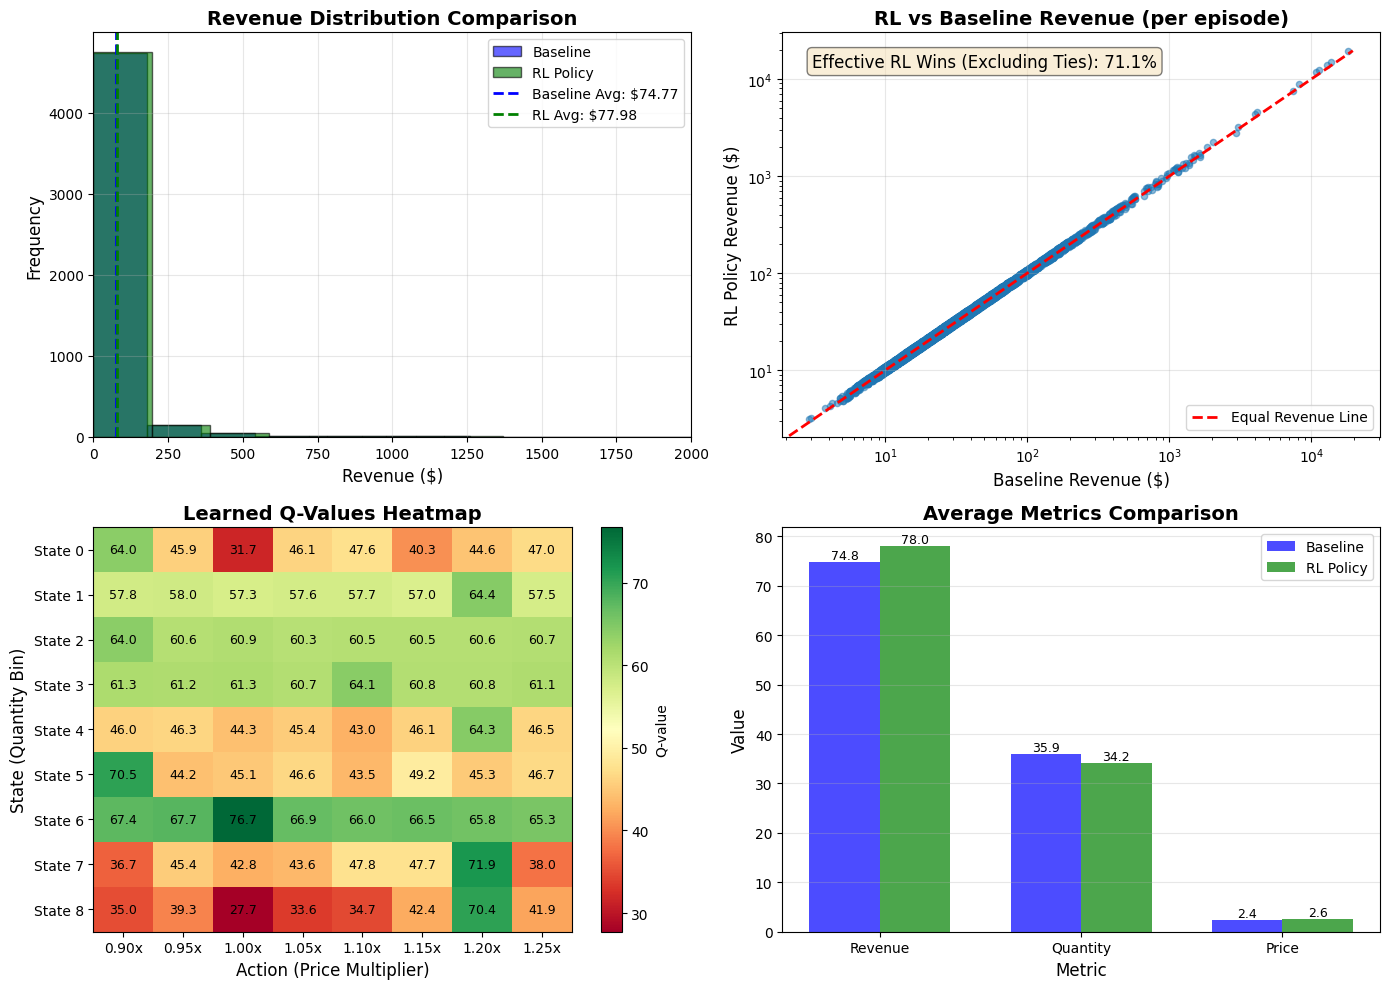


VISUALIZATION COMPLETE


In [18]:
# Create visualization of evaluation results
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Revenue Comparison Histogram
ax1 = axes[0, 0]
ax1.hist(eval_results['baseline_revenues'], bins=100, alpha=0.6, label='Baseline', color='blue', edgecolor='black')
ax1.hist(eval_results['rl_revenues'], bins=100, alpha=0.6, label='RL Policy', color='green', edgecolor='black')
ax1.axvline(eval_results['baseline_avg_revenue'], color='blue', linestyle='--', linewidth=2, label=f'Baseline Avg: ${eval_results["baseline_avg_revenue"]:.2f}')
ax1.axvline(eval_results['rl_avg_revenue'], color='green', linestyle='--', linewidth=2, label=f'RL Avg: ${eval_results["rl_avg_revenue"]:.2f}')
ax1.set_xlim([0.0, 2000.0])
ax1.set_xlabel('Revenue ($)', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.set_title('Revenue Distribution Comparison', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# 2. Scatter plot: RL vs Baseline Revenue
ax2 = axes[0, 1]
ax2.scatter(eval_results['baseline_revenues'], eval_results['rl_revenues'], alpha=0.5, s=20)
max_rev = max(max(eval_results['baseline_revenues']), max(eval_results['rl_revenues']))
min_rev = min(min(eval_results['baseline_revenues']), min(eval_results['rl_revenues']))
ax2.plot([min_rev, max_rev], [min_rev, max_rev], 'r--', linewidth=2, label='Equal Revenue Line')
ax2.set_xscale("log")
ax2.set_yscale("log")
ax2.set_xlabel('Baseline Revenue ($)', fontsize=12)
ax2.set_ylabel('RL Policy Revenue ($)', fontsize=12)
ax2.set_title('RL vs Baseline Revenue (per episode)', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3)

# Add text showing win rate
effective_win_rate = 100.0 * eval_results['stats']['sign_test_binom']['wins'] / max(1, eval_results['stats']['sign_test_binom']['n_eff'])
ax2.text(0.05, 0.95, f'Effective RL Wins (Excluding Ties): {effective_win_rate:.1f}%', transform=ax2.transAxes, 
         fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 3. Q-value heatmap
ax3 = axes[1, 0]
im = ax3.imshow(Q, aspect='auto', cmap='RdYlGn', interpolation='nearest')
ax3.set_xlabel('Action (Price Multiplier)', fontsize=12)
ax3.set_ylabel('State (Quantity Bin)', fontsize=12)
ax3.set_title('Learned Q-Values Heatmap', fontsize=14, fontweight='bold')
ax3.set_xticks(range(len(actions)))
ax3.set_xticklabels([f'{a:.2f}x' for a in actions])
ax3.set_yticks(range(Q.shape[0]))
ax3.set_yticklabels([f'State {i}' for i in range(Q.shape[0])])
plt.colorbar(im, ax=ax3, label='Q-value')

# Add annotations for best actions
for i in range(Q.shape[0]):
    for j in range(Q.shape[1]):
        text = ax3.text(j, i, f'{Q[i, j]:.1f}',
                       ha="center", va="center", color="black", fontsize=9)

# 4. Bar chart: Average metrics comparison
ax4 = axes[1, 1]
metrics = ['Revenue', 'Quantity', 'Price']
baseline_vals = [
    eval_results['baseline_avg_revenue'],
    eval_results['baseline_avg_quantity'],
    eval_results['baseline_avg_price']
]
rl_vals = [
    eval_results['rl_avg_revenue'],
    eval_results['rl_avg_quantity'],
    eval_results['rl_avg_price']
]

x = np.arange(len(metrics))
width = 0.35

bars1 = ax4.bar(x - width/2, baseline_vals, width, label='Baseline', color='blue', alpha=0.7)
bars2 = ax4.bar(x + width/2, rl_vals, width, label='RL Policy', color='green', alpha=0.7)

ax4.set_xlabel('Metric', fontsize=12)
ax4.set_ylabel('Value', fontsize=12)
ax4.set_title('Average Metrics Comparison', fontsize=14, fontweight='bold')
ax4.set_xticks(x)
ax4.set_xticklabels(metrics)
ax4.legend()
ax4.grid(alpha=0.3, axis='y')

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}',
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

print("\n" + "=" * 70)
print("VISUALIZATION COMPLETE")
print("=" * 70)
